In [1]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import cartiflette.s3
import numpy as np
import matplotlib as mpl
import math
import unidecode 
import string

from matplotlib.pyplot import gray
from geopandas import GeoDataFrame
from matplotlib import cm
from cartiflette.download import get_vectorfile_ign

In [2]:
df = pd.read_csv("Final Dataset MODS203.csv")
df = df.drop(columns=["Payment_accepted"])
df = df.dropna()
df = df.drop_duplicates()
df

,Name,Type,Speciality,Address,City,Postal_Code
0,Nathalie GARNIER-VIOUGEAT,Physician,Oncologue médical,23 Rue Georges Bizet 75016,Paris,75116
1,Service de chirurgie cancer ORL - Institut Curie,Hospital,Centre de Lutte Contre le Cancer (CLCC),26 Rue d'Ulm,Paris,75005
2,Fabio GIORGIANO,Physician,Chirurgien général,21 Rue Balzac,Paris,75008
3,Hôpital Cochin - AP-HP,Hospital,Hôpital public,123 Boulevard de Port-Royal,Paris,75014
4,Marc Spielmann,Physician,Cancérologue,22 bis rue Georges Bizet,Paris,75116
...,...,...,...,...,...,...
27301,Catherine PERONNET,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27302,Jacques BOHBOT,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27304,Centre Municipal de Santé - Mitry Mory,Hospital,Centre de santé,4 Place Nelson Mandela,Mitry-Mory,77290
27305,Dépistage COVID Aéroport Roissy Charles de Gau...,Hospital,Centre de dépistage COVID-19,Terminal 2,Roissy-en-France,95700


### Dataset with the department only
We first drop the useless columns

In [3]:
df2 = df.drop('Address', axis=1, inplace=False).drop('Speciality', axis=1, inplace=False).drop('Type', axis=1, inplace=False).drop('City', axis=1, inplace=False)

We then handle the non-normalised values

In [4]:
df2['Postal_Code'] = df2['Postal_Code'].replace(['59462 Cedex'], '59')
df2['Postal_Code'] = df2['Postal_Code'].replace(['BOULOGNESURMER'], '62')
df2['Postal_Code'] = df2['Postal_Code'].replace(['FORTMAHONPLAGE'], '80')
df2['Postal_Code'] = df2['Postal_Code'].replace(['L-4048'], '40')
df2['Postal_Code'] = df2['Postal_Code'].replace(['LALLAING'], '59')

We subsequently convert all the values to *int* format

In [5]:
for k in df.index:
    df2['Postal_Code'][k] = int(np.floor(int(df2['Postal_Code'][k])/1000))
    if df2['Postal_Code'][k] < 10:
        df2['Postal_Code'][k] = '0'+str(df2['Postal_Code'][k])
    else :
        df2['Postal_Code'][k] = str(df2['Postal_Code'][k])
      
df2

,Name,Postal_Code
0,Nathalie GARNIER-VIOUGEAT,75
1,Service de chirurgie cancer ORL - Institut Curie,75
2,Fabio GIORGIANO,75
3,Hôpital Cochin - AP-HP,75
4,Marc Spielmann,75
...,...,...
27301,Catherine PERONNET,93
27302,Jacques BOHBOT,93
27304,Centre Municipal de Santé - Mitry Mory,77
27305,Dépistage COVID Aéroport Roissy Charles de Gau...,95


We create a new Dataframe containing the total number of doctors in each given department 

In [6]:
total_by_postcod = df2.groupby(by='Postal_Code', as_index=False).agg({'Name': pd.Series.nunique})
total_by_postcod.sort_values('Name', ascending = False)
total_by_postcod

,Postal_Code,Name
0,00,6
1,01,61
2,02,82
3,03,10
4,04,3
...,...,...
87,92,1084
88,93,756
89,94,838
90,95,279


### Dataset with population density

In [7]:
dens = pd.read_csv('Densite_pop_INSEE.csv', encoding='latin1')
dens

,DEP,Densité
0,48,15
1,23,21
2,4,24
3,15,25
4,5,25
...,...,...
93,95,994
94,94,5702
95,93,6918
96,92,9200


We normalize the dataset

In [8]:
dens.rename(columns = {'DEP':'Postal_Code'}, inplace = True)
dens.rename(columns = {'Densité':'Density'}, inplace = True)

for k in dens.index:
    if dens['Postal_Code'][k] < 10:
        dens['Postal_Code'][k] = '0'+str(dens['Postal_Code'][k])
    else :
        dens['Postal_Code'][k] = str(dens['Postal_Code'][k])

dens

,Postal_Code,Density
0,48,15
1,23,21
2,04,24
3,15,25
4,05,25
...,...,...
93,95,994
94,94,5702
95,93,6918
96,92,9200


### Dataset with departments

In [9]:
dep_tot = get_vectorfile_ign(
  level = "DEPARTEMENT", field = "metropole",
  source = "COG", provider="opendatarchives")
dep_tot

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\solal\AppData\Local\Temp/COG-2022


,ID,NOM_M,NOM,INSEE_DEP,INSEE_REG,geometry
0,DEPARTEM_FXX_00000000001,AIN,Ain,01,84,"POLYGON ((838383.200 6570485.800, 838483.800 6..."
1,DEPARTEM_FXX_00000000002,AISNE,Aisne,02,32,"POLYGON ((708719.000 6956305.000, 708718.700 6..."
2,DEPARTEM_FXX_00000000003,CORSE-DU-SUD,Corse-du-Sud,2A,94,"MULTIPOLYGON (((1165315.300 6103089.200, 11653..."
3,DEPARTEM_FXX_00000000004,HAUTE-CORSE,Haute-Corse,2B,94,"MULTIPOLYGON (((1222168.900 6235253.100, 12221..."
4,DEPARTEM_FXX_00000000005,ALLIER,Allier,03,84,"POLYGON ((664478.800 6602292.500, 664503.600 6..."
...,...,...,...,...,...,...
91,DEPARTEM_FXX_00000000092,ESSONNE,Essonne,91,11,"POLYGON ((629444.100 6836670.800, 629365.600 6..."
92,DEPARTEM_FXX_00000000093,HAUTS-DE-SEINE,Hauts-de-Seine,92,11,"POLYGON ((642868.900 6869240.500, 642874.900 6..."
93,DEPARTEM_FXX_00000000094,SEINE-SAINT-DENIS,Seine-Saint-Denis,93,11,"POLYGON ((660415.900 6872923.300, 660423.700 6..."
94,DEPARTEM_FXX_00000000095,VAL-DE-MARNE,Val-de-Marne,94,11,"POLYGON ((650731.000 6857288.700, 650942.200 6..."


We drop the unused columns as well as Corsica as it was not scapped.

In [10]:
dep = dep_tot.drop('ID', axis=1, inplace=False).drop('INSEE_REG', axis=1, inplace=False).drop('NOM', axis=1, inplace=False)
dep = dep.drop(2).drop(3)
dep.rename(columns = {'INSEE_DEP':'Postal_Code'}, inplace = True)

### Dataset with sunlight

In [11]:
sun = pd.read_csv('sunlight.csv', encoding='latin1')
sun

,Départements,Temps d'enseillement (jours/an)
0,Ain,182
1,Aisne,142
2,Allier,161
3,Alpes de Haute Provence,241
4,Hautes-Alpes,232
...,...,...
88,Essonne,148
89,Hauts-de-Seine,107
90,Seine-Saint-Denis,126
91,Val-de-Marne,126


Let us normalize the dataset

In [12]:
sun.rename(columns = {'Départements':'NOM_M'}, inplace = True)
sun.rename(columns = {'Temps d\'enseillement (jours/an)': 'Sunlight (d/yr)'}, inplace = True)

for k in sun.index:
    sun.loc[k,'NOM_M'] = (unidecode.unidecode(sun['NOM_M'][k])).upper()
    sun.loc[k,'NOM_M'] = sun['NOM_M'][k].replace(' ', '-')
    if k == 87:
        sun.loc[k,'NOM_M'] = sun['NOM_M'][k].replace('-', ' ') #territoire de belfort, which has a specific normalization in the previous table
sun

,NOM_M,Sunlight (d/yr)
0,AIN,182
1,AISNE,142
2,ALLIER,161
3,ALPES-DE-HAUTE-PROVENCE,241
4,HAUTES-ALPES,232
...,...,...
88,ESSONNE,148
89,HAUTS-DE-SEINE,107
90,SEINE-SAINT-DENIS,126
91,VAL-DE-MARNE,126


### Mixing the datasets

In [13]:
dep = GeoDataFrame(pd.merge(total_by_postcod, dep, on='Postal_Code', how='right'))
dep = GeoDataFrame(pd.merge(dens, dep, on='Postal_Code', how='right'))
dep = GeoDataFrame(pd.merge(sun, dep, on='NOM_M', how='right'))
dep

,NOM_M,Sunlight (d/yr),Postal_Code,Density,Name,geometry
0,AIN,182.0,01,112,61.0,"POLYGON ((838383.200 6570485.800, 838483.800 6..."
1,AISNE,142.0,02,72,82.0,"POLYGON ((708719.000 6956305.000, 708718.700 6..."
2,ALLIER,161.0,03,46,10.0,"POLYGON ((664478.800 6602292.500, 664503.600 6..."
3,ALPES-DE-HAUTE-PROVENCE,241.0,04,24,3.0,"POLYGON ((910451.400 6342553.000, 910484.700 6..."
4,HAUTES-ALPES,232.0,05,25,69.0,"POLYGON ((933490.000 6411083.800, 933530.500 6..."
...,...,...,...,...,...,...
89,ESSONNE,148.0,91,719,265.0,"POLYGON ((629444.100 6836670.800, 629365.600 6..."
90,HAUTS-DE-SEINE,107.0,92,9200,1084.0,"POLYGON ((642868.900 6869240.500, 642874.900 6..."
91,SEINE-SAINT-DENIS,126.0,93,6918,756.0,"POLYGON ((660415.900 6872923.300, 660423.700 6..."
92,VAL-DE-MARNE,126.0,94,5702,838.0,"POLYGON ((650731.000 6857288.700, 650942.200 6..."


### Plotting the first map
We create a normalizing function in order to create our gradient of colour

In [162]:
color_used = cm.get_cmap('turbo')
tab_colors = color_used(np.linspace(0, 1, 101))

def give_color1(nb):
    if nb > 300:
        nb = 300
    nb_norm = nb/300
    nb_norm = round(nb_norm*100)
    return(list(tab_colors[nb_norm]))

We then plot the map of the number of doctors depending on the department.

**Warning : the map can take up to 3min to plot (usually less than 2min)**

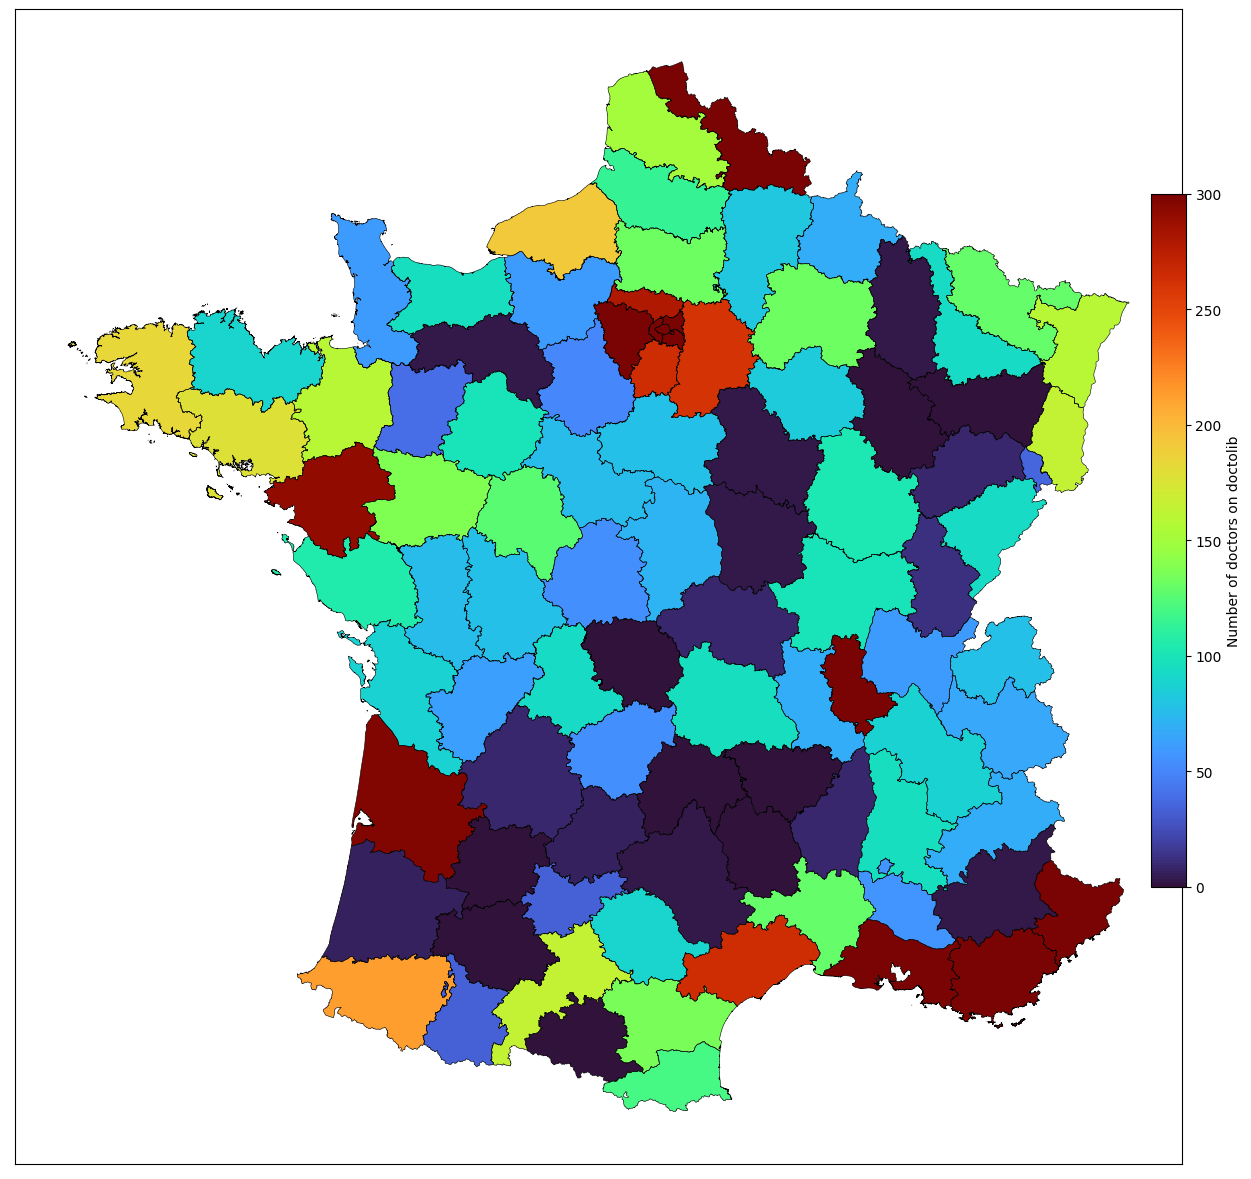

In [163]:
fig = plt.figure(1, figsize=(25,15))
ax = fig.add_subplot()

for k in dep.index:
    current_dep = dep.iloc[[k]]
    current_dep.boundary.plot(ax=ax, color='Black', linewidth=.4)
    if math.isnan(current_dep['Name']):
        current_dep.plot(ax=ax, color= give_color1(0), figsize=(12, 12))
    else : 
        current_dep.plot(ax=ax, color= give_color1(int(current_dep['Name'])), figsize=(12, 12))

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=300, clip=False), cmap='turbo'),label="Number of doctors on doctolib", orientation="vertical", shrink = 0.6, anchor =(-0.50, 0.6))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Plotting the 2nd map: density
We create a column containing the number of doctor divided by the density of the department and plot the map accordingly

In [14]:
dep["Doct_by_density"] = dep["Name"]/dep["Density"]
dep

,NOM_M,Sunlight (d/yr),Postal_Code,Density,Name,geometry,Doct_by_density
0,AIN,182.0,01,112,61.0,"POLYGON ((838383.200 6570485.800, 838483.800 6...",0.544643
1,AISNE,142.0,02,72,82.0,"POLYGON ((708719.000 6956305.000, 708718.700 6...",1.138889
2,ALLIER,161.0,03,46,10.0,"POLYGON ((664478.800 6602292.500, 664503.600 6...",0.217391
3,ALPES-DE-HAUTE-PROVENCE,241.0,04,24,3.0,"POLYGON ((910451.400 6342553.000, 910484.700 6...",0.125000
4,HAUTES-ALPES,232.0,05,25,69.0,"POLYGON ((933490.000 6411083.800, 933530.500 6...",2.760000
...,...,...,...,...,...,...,...
89,ESSONNE,148.0,91,719,265.0,"POLYGON ((629444.100 6836670.800, 629365.600 6...",0.368567
90,HAUTS-DE-SEINE,107.0,92,9200,1084.0,"POLYGON ((642868.900 6869240.500, 642874.900 6...",0.117826
91,SEINE-SAINT-DENIS,126.0,93,6918,756.0,"POLYGON ((660415.900 6872923.300, 660423.700 6...",0.109280
92,VAL-DE-MARNE,126.0,94,5702,838.0,"POLYGON ((650731.000 6857288.700, 650942.200 6...",0.146966


In [142]:
dep['Doct_by_density'].describe()

count    89.000000
mean      0.884322
std       0.633162
min       0.016129
25%       0.280684
50%       0.893204
75%       1.284965
max       2.760000
Name: Doct_by_density, dtype: float64

We use the previous values to recompute the normalizing function

In [143]:
color_used = cm.get_cmap('hot_r')
tab_colors = color_used(np.linspace(0, 1, 101))

def give_color2(nb):
    if nb > 2:
        nb = 2
    nb_norm = nb/2
    nb_norm = round(nb_norm*100)
    return(list(tab_colors[nb_norm]))

**Warning : the map can take up to 6min to plot (usually less than 3min)**

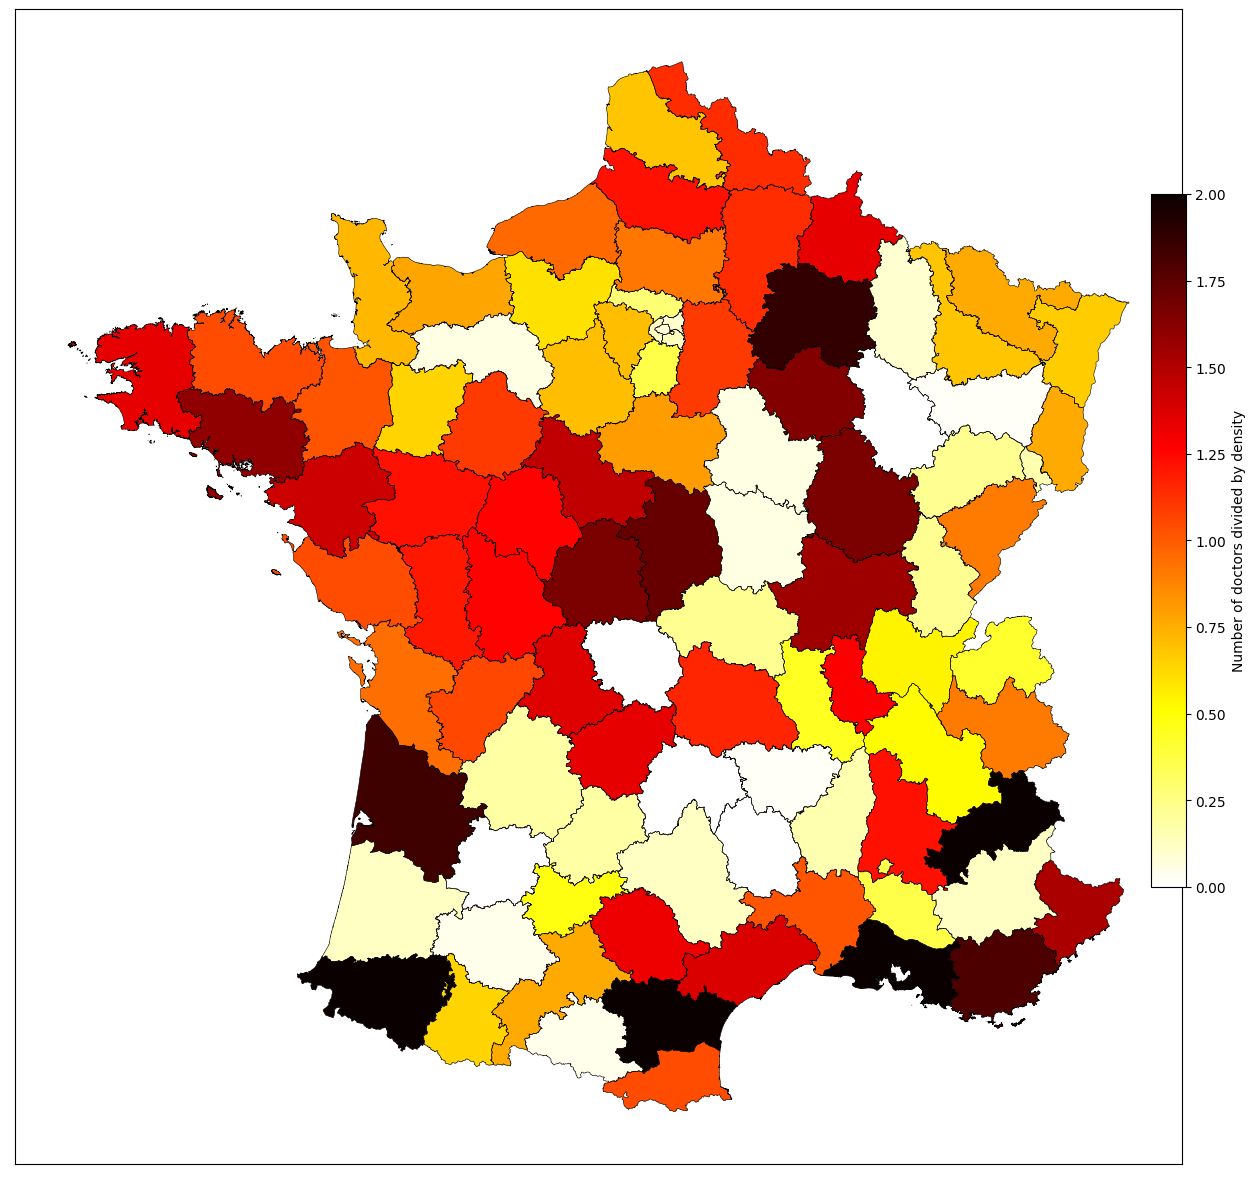

In [144]:
fig = plt.figure(1, figsize=(25,15))
ax = fig.add_subplot()

for k in dep.index:
    current_dep = dep.iloc[[k]]
    current_dep.boundary.plot(ax=ax, color='Black', linewidth=.4)
    if math.isnan(current_dep['Doct_by_density']):
        current_dep.plot(ax=ax, color= give_color2(0), figsize=(12, 12))
    else : 
        current_dep.plot(ax=ax, color= give_color2(float(current_dep['Doct_by_density'])), figsize=(12, 12))

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=2, clip=False), cmap='hot_r'),label="Number of doctors divided by density", orientation="vertical", shrink = 0.6, anchor =(-0.50, 0.6))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Plotting the 3rd map: sunlight

In [15]:
dep["Doc_sun"] = dep["Name"]*dep["Sunlight (d/yr)"]
dep

,NOM_M,Sunlight (d/yr),Postal_Code,Density,Name,geometry,Doct_by_density,Doc_sun
0,AIN,182.0,01,112,61.0,"POLYGON ((838383.200 6570485.800, 838483.800 6...",0.544643,11102.0
1,AISNE,142.0,02,72,82.0,"POLYGON ((708719.000 6956305.000, 708718.700 6...",1.138889,11644.0
2,ALLIER,161.0,03,46,10.0,"POLYGON ((664478.800 6602292.500, 664503.600 6...",0.217391,1610.0
3,ALPES-DE-HAUTE-PROVENCE,241.0,04,24,3.0,"POLYGON ((910451.400 6342553.000, 910484.700 6...",0.125000,723.0
4,HAUTES-ALPES,232.0,05,25,69.0,"POLYGON ((933490.000 6411083.800, 933530.500 6...",2.760000,16008.0
...,...,...,...,...,...,...,...,...
89,ESSONNE,148.0,91,719,265.0,"POLYGON ((629444.100 6836670.800, 629365.600 6...",0.368567,39220.0
90,HAUTS-DE-SEINE,107.0,92,9200,1084.0,"POLYGON ((642868.900 6869240.500, 642874.900 6...",0.117826,115988.0
91,SEINE-SAINT-DENIS,126.0,93,6918,756.0,"POLYGON ((660415.900 6872923.300, 660423.700 6...",0.109280,95256.0
92,VAL-DE-MARNE,126.0,94,5702,838.0,"POLYGON ((650731.000 6857288.700, 650942.200 6...",0.146966,105588.0


In [245]:
max_nb = dep['Doc_sun'].max()
max_nb

232180.0

In [246]:
dep['Doc_sun'].describe()

count        89.000000
mean      26735.471910
std       39538.922866
min         111.000000
25%        8040.000000
50%       14800.000000
75%       25116.000000
max      232180.000000
Name: Doc_sun, dtype: float64

In [254]:
color_used = cm.get_cmap('gnuplot2')
tab_colors = color_used(np.linspace(0, 1, 101))

def give_color3(nb):
    if nb > 50000:
        nb = 50000
    nb_norm = nb/50000
    nb_norm = round(nb_norm*100)
    return(list(tab_colors[nb_norm]))

**Warning : the map can take up to 6min to plot (usually less than 3min)**

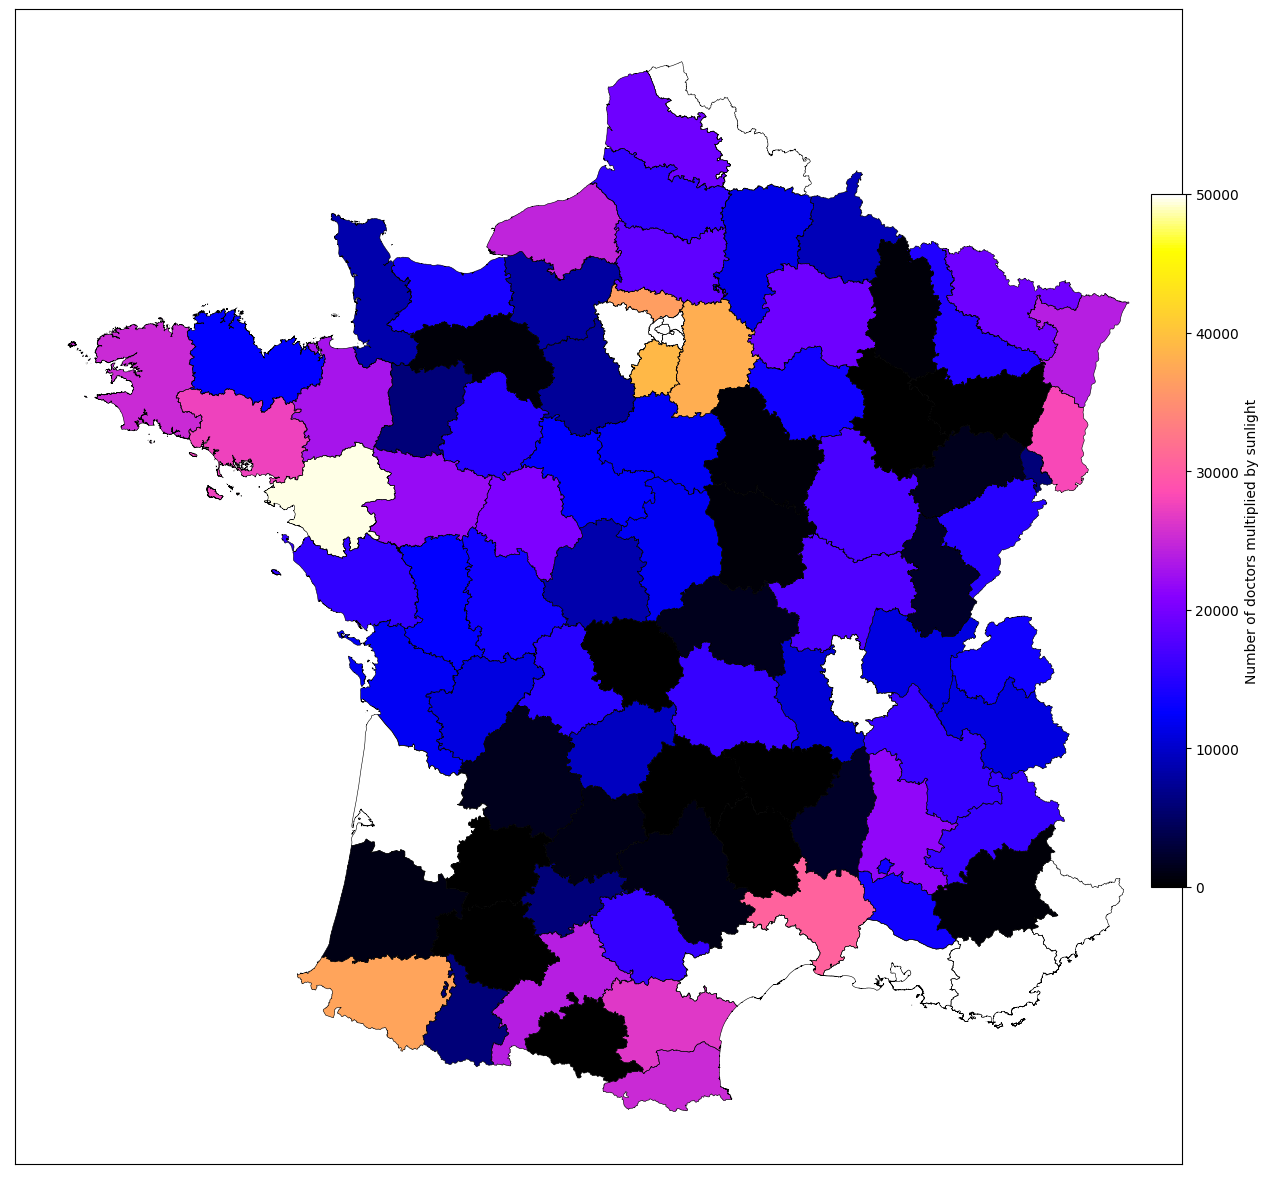

In [255]:
fig = plt.figure(1, figsize=(25,15))
ax = fig.add_subplot()

for k in dep.index:
    current_dep = dep.iloc[[k]]
    current_dep.boundary.plot(ax=ax, color='Black', linewidth=.4)
    if math.isnan(current_dep['Doc_sun']):
        current_dep.plot(ax=ax, color= give_color3(0), figsize=(12, 12))

    else : 
        current_dep.plot(ax=ax, color= give_color3(float(current_dep['Doc_sun'])), figsize=(12, 12))


plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=50000, clip=False), cmap='gnuplot2'),label="Number of doctors multiplied by sunlight", orientation="vertical", shrink = 0.6, anchor =(-0.50, 0.6))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Correlation Matrix

In [16]:
dep.rename(columns = {'Name':'Nb_Doc'}, inplace = True)
corr = dep.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,Sunlight (d/yr),Density,Nb_Doc,Doct_by_density,Doc_sun
Sunlight (d/yr),1.00,-0.24,-0.11,0.32,0.11
Density,-0.24,1.00,0.80,-0.23,0.63
Nb_Doc,-0.11,0.80,1.00,0.07,0.95
Doct_by_density,0.32,-0.23,0.07,1.00,0.22
Doc_sun,0.11,0.63,0.95,0.22,1.00
